<a href="https://colab.research.google.com/github/olonok69/LLM_Notebooks/blob/main/image/Inference_image_classification_NSWF_full.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Model https://huggingface.co/google/vit-base-patch16-224-in21k

### From Hugging Face

####Vision Transformer (base-sized model)
Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224. It was introduced in the paper An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al. and first released in this repository. However, the weights were converted from the timm repository by Ross Wightman, who already converted the weights from JAX to PyTorch. Credits go to him.

Disclaimer: The team releasing ViT did not write a model card for this model so this model card has been written by the Hugging Face team.

### Model description
The Vision Transformer (ViT) is a transformer encoder model (BERT-like) pretrained on a large collection of images in a supervised fashion, namely ImageNet-21k, at a resolution of 224x224 pixels.

Images are presented to the model as a sequence of fixed-size patches (resolution 16x16), which are linearly embedded. One also adds a [CLS] token to the beginning of a sequence to use it for classification tasks. One also adds absolute position embeddings before feeding the sequence to the layers of the Transformer encoder.

#### Note
This model does not provide any fine-tuned heads, as these were zero'd by Google researchers. However, the model does include the pre-trained pooler, which can be used for downstream tasks (such as image classification).

By pre-training the model, it learns an inner representation of images that can then be used to extract features useful for downstream tasks: if you have a dataset of labeled images for instance, you can train a standard classifier by placing a linear layer on top of the pre-trained encoder. One typically places a linear layer on top of the [CLS] token, as the last hidden state of this token can be seen as a representation of an entire image.

In [1]:
# blocks output in Colab 💄
%%capture

! pip install datasets transformers
! pip install accelerate wandb bitsandbytes -U -q

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import wandb

# https://wandb.ai/site

PROJECT = "NSFW-fine_tune"
MODEL_NAME = 'google/vit-base-patch16-224-in21k'
DATASET = "NSFW"
wandb.init(project=PROJECT, # the project I am working on
           tags=[MODEL_NAME, DATASET],
           notes ="Classification Fine Tune NSFW dataset with google/vit-base-patch16-224-in21k") # the Hyperparameters I want to keep track of

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [4]:
path_data_train = "/content/drive/MyDrive/data/train/"
path_data_validation = "/content/drive/MyDrive/data/validation"
path_data_test = "/content/drive/MyDrive/data/test"

In [5]:
run = wandb.init()
artifact = run.use_artifact('olonok69/NSFW-fine_tune/nsfw_3600:v1', type='model')
artifact_dir = artifact.download()

wandb: Downloading large artifact nsfw_3600:v1, 327.34MB. 4 files... 
wandb:   4 of 4 files downloaded.  
Done. 0:0:14.9


In [60]:
from transformers import ViTImageProcessor, ViTModel, ViTForImageClassification
from PIL import Image as PImage
import matplotlib.pyplot as plt
import torch
from datasets import ClassLabel, Dataset, Features, Image, Value, Sequence, DatasetDict
import numpy as np

In [41]:
drawing_image = "/content/drive/MyDrive/data/test/drawings/0026b6c4a19415a926ed50acd07d99c8739bc45f257dc6a7714df368a7b2a761.jpg"
hentai_image = "/content/drive/MyDrive/data/test/hentai/058f26ed8e4fa8994969a5f4a1ec5a5f3ddfd3850ebe9182f541a96a00f58c5b.jpg"
neutral_image = "/content/drive/MyDrive/data/test/neutral/05ff38e69d1157f669cc249b2b331f55bdafdd3c5fc5db74d50ad0dfb13ddd18.jpg"
porn_image = "/content/drive/MyDrive/data/test/porn/05f450b6de8c546bae642f62856e43f5068c815d706e84f7a0f5605201b92c22.jpg"
sexy_image = "/content/drive/MyDrive/data/test/sexy/5b7628922358486082189cc38fa77cd1a0ec58b5d6ab4e59d469254ac83eab29.jpg"

In [42]:
image = PImage.open(drawing_image)

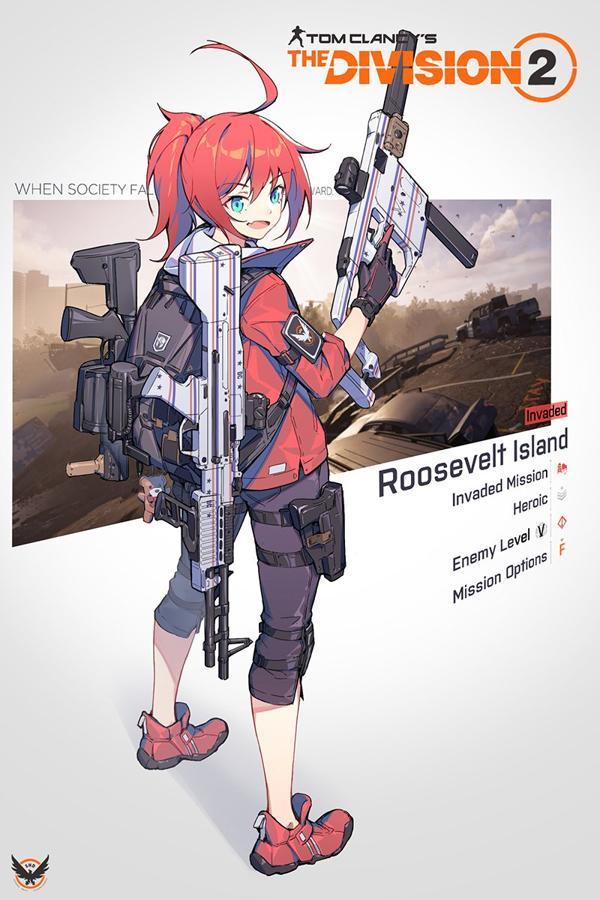

In [43]:
image

In [44]:
image.size

(600, 900)

In [45]:
label_dic={"drawings":0, "hentai": 1,"neutral":2, "porn": 3,"sexy": 4}

In [61]:
processor = ViTImageProcessor.from_pretrained(artifact_dir)
model = ViTForImageClassification.from_pretrained(artifact_dir)


In [49]:
inputs = processor(images=image, return_tensors="np")

In [50]:
inputs['pixel_values'].shape

(1, 3, 224, 224)

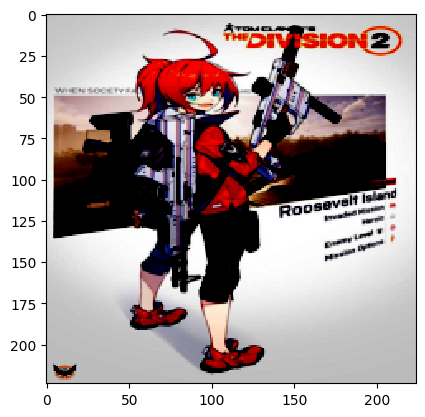

In [51]:
plt.imshow(np.transpose(inputs['pixel_values'][0], (1, 2, 0)), interpolation='nearest')

In [62]:
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [63]:
logits = outputs.logits

In [65]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: drawings


In [73]:
probs= torch.softmax(logits, dim=1).detach().numpy()

In [75]:
def get_key(dict, value):
  for key, val in dict.items():
    if val == value:
      return key
  return "Value not found"





b


In [86]:
probs = list(probs[0])
probs

[0.95975107, 0.03461799, 0.0047981488, 0.00047462143, 0.00035820052]

In [88]:
for prob, key in zip(probs,range(0,len(probs))):
  label = get_key(label_dic, key)
  print(label, prob)

drawings 0.95975107
hentai 0.03461799
neutral 0.0047981488
porn 0.00047462143
sexy 0.00035820052


In [89]:
image = PImage.open(hentai_image)
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
probs= torch.softmax(logits, dim=1).detach().numpy()
probs = list(probs[0])
print("Predicted class:", model.config.id2label[predicted_class_idx])
for prob, key in zip(probs,range(0,len(probs))):
  label = get_key(label_dic, key)
  print(label, prob)

Predicted class: hentai
drawings 0.020386774
hentai 0.97757876
neutral 0.00056196435
porn 0.00040432098
sexy 0.0010682944


In [90]:
image = PImage.open(neutral_image)
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
probs= torch.softmax(logits, dim=1).detach().numpy()
probs = list(probs[0])
print("Predicted class:", model.config.id2label[predicted_class_idx])
for prob, key in zip(probs,range(0,len(probs))):
  label = get_key(label_dic, key)
  print(label, prob)


Predicted class: neutral
drawings 0.047798723
hentai 0.0023838948
neutral 0.94809103
porn 0.0008573145
sexy 0.0008691654


In [91]:
image = PImage.open(porn_image)
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
probs= torch.softmax(logits, dim=1).detach().numpy()
probs = list(probs[0])
print("Predicted class:", model.config.id2label[predicted_class_idx])
for prob, key in zip(probs,range(0,len(probs))):
  label = get_key(label_dic, key)
  print(label, prob)

Predicted class: porn
drawings 0.0004882993
hentai 0.0007496129
neutral 0.00031814477
porn 0.9970853
sexy 0.0013586894


In [92]:
image = PImage.open(sexy_image)
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
probs= torch.softmax(logits, dim=1).detach().numpy()
probs = list(probs[0])
print("Predicted class:", model.config.id2label[predicted_class_idx])
for prob, key in zip(probs,range(0,len(probs))):
  label = get_key(label_dic, key)
  print(label, prob)

Predicted class: sexy
drawings 0.0031286834
hentai 0.0010012389
neutral 0.3716119
porn 0.017960133
sexy 0.6062981


In [93]:
image = PImage.open(drawing_image)
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
probs= torch.softmax(logits, dim=1).detach().numpy()
probs = list(probs[0])
print("Predicted class:", model.config.id2label[predicted_class_idx])
for prob, key in zip(probs,range(0,len(probs))):
  label = get_key(label_dic, key)
  print(label, prob)

Predicted class: drawings
drawings 0.95975107
hentai 0.03461799
neutral 0.0047981488
porn 0.00047462143
sexy 0.00035820052


In [94]:
wandb.finish()